In [1]:
import os
import diplib as dip
import numpy as np
from pathlib import Path

# --- Configuration (adjust these paths) ---
input_dir  = r"2023Assignment05Images"
output_dir = r"output"
os.makedirs(output_dir, exist_ok=True)

# --- Selected final dataset of each embryo ---
final_datset = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21b", # instead of 20
    "22",
    "23",
    "24", # instead of 24b
    "25",
    "26b", # instead of 26
    "27",
    "28",
    "29",
    "30",
    "31",
    "32b", # instead of 32
    "33",
    "34b", # instead of 34
    "35b", # instead of 35
    "36", # instead of 36b
    "37",
    "38b", # instead of 38
    "39",
    "40",
    "41", # instead of 41b
    "42",
    "43", # instead of 43b
    "44",
    "45b", # instead of 45
    "46", # instead of 46b and 46c
    "47", # instead of 47b
    "48",
    "49",
    "50", # instead of 50b
    "51",
    "52",
    "53", # instead of 53 flipped
    "54", # instead of 54b
    "55",
    "56b", # instead of 56
    "57",
    "58" # instead of 58b
]

img_paths = [os.path.join(input_dir, f"w8t1t2_d7_{num}.tif") for num in final_datset]


DIPlib -- a quantitative image analysis library
Version 3.5.2 (Dec 27 2024)
For more information see https://diplib.org


Original


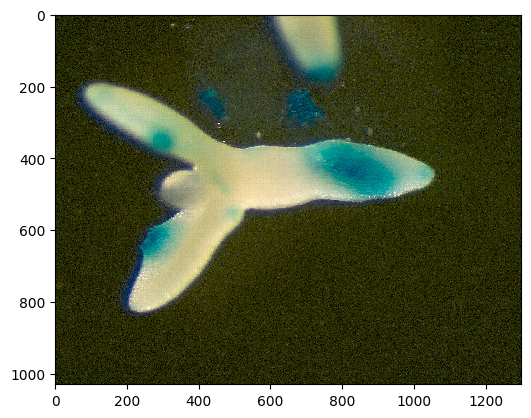

Blue channel


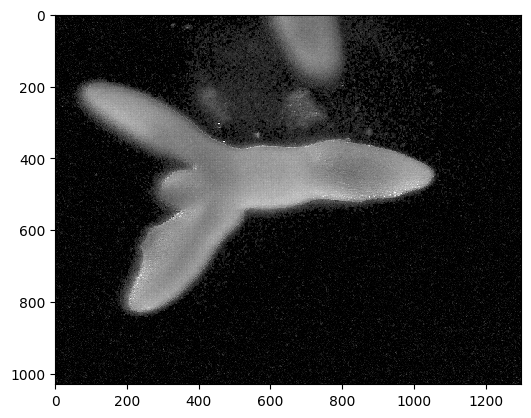

Blue channel clipped to 20000


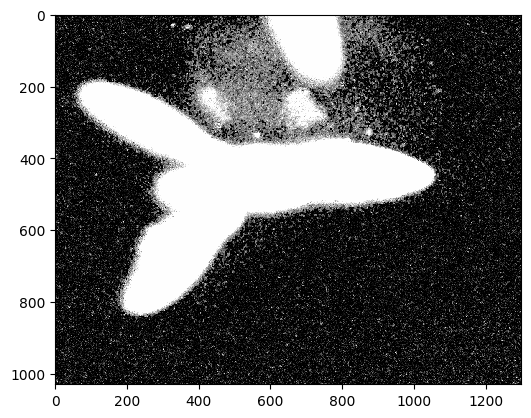

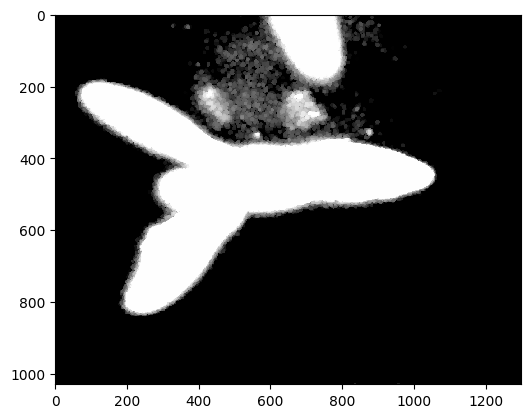

Threshold on blue channel


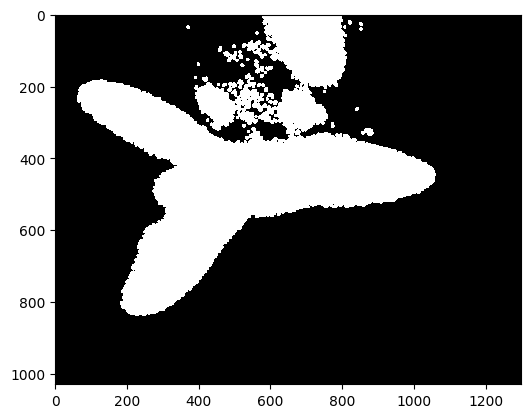

Fill larger holes left


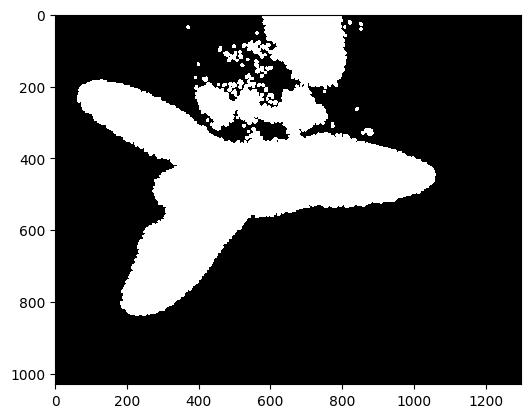

Binary mask of largest object


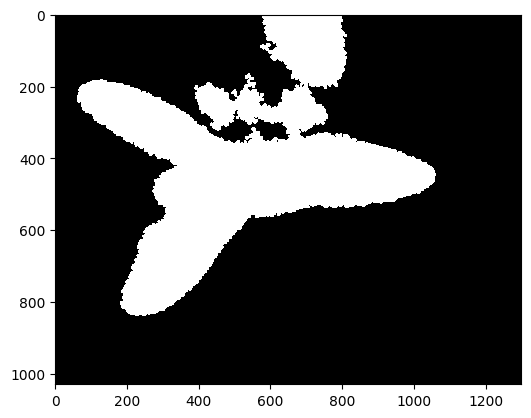

In [ ]:
# -----------------------------------------------------
# Q1.1: Segmentation technique to prepare the embryos
# -----------------------------------------------------

def embryo_segmentaion(img_path, show_intermediates=False):
    img = dip.ImageRead(img_path)
    if show_intermediates:
        print("Original")
        img.Show()
    
    # Extract green and blue channels
    img_blue = img(2)
    if show_intermediates:
        print("Blue channel")
        img_blue.Show()
    # Clip upper blue intensity value
    clip_value = 20000
    img_blue = dip.ClipHigh(img_blue, clip_value)
    if show_intermediates:
        print(f"Blue channel clipped to {clip_value}")
        img_blue.Show()

    # Gray scale openening to remove noise
    img_blue = dip.Opening(img_blue, dip.SE((10,10), "elliptic"))
    if show_intermediates:
        img_blue.Show()

    # Threshold on the green and blue channel, and OR the results
    img_bin = dip.OtsuThreshold(img_blue)
    if show_intermediates:
        print("Threshold on blue channel")
        img_bin.Show()

    # Apply opening to remove small artifacts outside embtyo and define embryo edges
    #img_bin = dip.Opening(img_bin, dip.SE((3,3), "elliptic"))
    #if show_intermediates:
    #    print("Opening to remove small artifacts")
    #    img_bin.Show()

    ## Apply closing to fill small gaps in embryo
    #img_bin = dip.Closing(img_bin, dip.SE((5,5), "elliptic"))
    #if show_intermediates:
    #    print("Closing to fill small gaps")
    #    img_bin.Show()

    # Fill larges holes left in the embryo
    img_bin = dip.FillHoles(img_bin, connectivity=2)
    if show_intermediates:
        print("Fill larger holes left")
        img_bin.Show()

    # Closing to remove connecting objects
    img_bin = dip.Closing(img_bin, dip.SE((20,20)))
    if show_intermediates:
        print("Fill larger holes left")
        img_bin.Show()


    # Label remaining objects
    img_lbl = dip.Label(img_bin)
    # Measure object sizes
    m = dip.MeasurementTool.Measure(img_lbl, img, ["Size"])
    # Derive largest object
    largest_lbl = np.argmax(m["Size"]) + 1

    # Create the binary image mask for the largest object
    embryo_mask = img_lbl == largest_lbl
    if show_intermediates:
        print("Binary mask of largest object")
        embryo_mask.Show()

    return img, embryo_mask


# -----------------------------------------------------
# Q1.2: Resize image for use in report
# -----------------------------------------------------

def rescale_image(img, scalar = 0.25):
    new_img = dip.Resampling(img, zoom=scalar)
    return new_img

def write_rescaled_images(img_path, img, embryo_mask):
    rescale_img = rescale_image(img)
    rescale_embryo_mask = rescale_image(embryo_mask)

    rescale_img_dir = os.path.join(output_dir, "rescale_img")
    rescale_embryo_mask_dir = os.path.join(output_dir, "rescale_embryo_mask")
    os.makedirs(rescale_img_dir, exist_ok=True)
    os.makedirs(rescale_embryo_mask_dir, exist_ok=True)

    rescale_img_path = os.path.join(rescale_img_dir, Path(img_path).stem)
    rescale_embryo_mask_path = os.path.join(rescale_embryo_mask_dir, Path(img_path).stem)

    dip.ImageWritePNG(rescale_img, rescale_img_path)
    dip.ImageWritePNG(rescale_embryo_mask, rescale_embryo_mask_path)

#for img_path in img_paths:
#    img, embryo_mask = embryo_segmentaion(img_path)
#    write_rescaled_images(img_path, img, embryo_mask)

img, embryo_mask = embryo_segmentaion(img_paths[2], show_intermediates=True)

